In [1]:
import math
import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from FeatureEngineering_2 import *

from joblib import dump, load
from AdvancedModel_helpers import *

In [2]:
if not os.path.exists("csv"):
    os.makedirs("csv")
for year in [2016,2017, 2018, 2019]: # 2020 has been excluded to be reserved as the test set
    read_a_season("../nhl_data/",year).to_csv('csv/tidy_{season}.csv'.format(season = year), sep = ',', index = False)

  0%|          | 0/5456 [00:00<?, ?it/s]

100%|██████████| 5456/5456 [01:42<00:00, 53.04it/s] 


### Consolidating and Sorting CSV Files into a Unified DataFrame

In [2]:
directory = 'csv'

# Get a list of csv file names within the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Sort the list of csv files
csv_files.sort()

# List to hold your DataFrames
dataframes_list = []

# Loop over the sorted list of csv files with tqdm for progress indication
for filename in tqdm(csv_files, desc="Loading files", unit="file"):
    file_path = os.path.join(directory, filename)
    df = pd.read_csv(file_path)
    dataframes_list.append(df)

# Concatenate all the DataFrames in the list into a single DataFrame
train_val_df = pd.concat(dataframes_list, ignore_index=True)

# Sort the DataFrame first by 'game_id' and then by 'event_idx'
train_val_df =train_val_df .sort_values(by=['game_id', 'event_idx'])

# Reset the index of the sorted DataFrame
train_val_df = train_val_df .reset_index(drop=True)

Loading files:  25%|██▌       | 1/4 [00:00<00:00,  8.59file/s]

Loading files: 100%|██████████| 4/4 [00:01<00:00,  3.36file/s]


In [3]:
train_val_df.head(10)

,game_id,event_idx,play_type,shot_type,shot_dist,game_time,goals_home,goals_away,attack_team_name,period,...,y_coord_last_event,Time_from_the_last_event,Distance_from_the_last_event,Rebound,change_shot_angle,Speed,x,y,angle_net,is_goal
0,2016020978,4,Shot,Wrist Shot,61.294372,9,0,0,Colorado Avalanche,1,...,0.0,9,45.453273,False,NaN,5.050364,-35.0,29.0,-28.237446,0
1,2016020978,5,Shot,Wrist Shot,8.944272,10,0,0,Colorado Avalanche,1,...,29.0,1,54.230987,True,-35.197503,54.230987,-85.0,8.0,-63.434949,0
2,2016020978,16,Shot,Wrist Shot,39.000000,243,0,0,Colorado Avalanche,1,...,35.0,43,108.853112,False,NaN,2.531468,-53.0,15.0,-22.619865,0
3,2016020978,17,Shot,Wrist Shot,39.962482,253,0,0,Carolina Hurricanes,1,...,15.0,10,108.166538,True,25.671421,10.816654,55.0,21.0,31.701430,0
4,2016020978,20,Shot,Wrist Shot,18.867962,349,0,0,Colorado Avalanche,1,...,-32.0,56,20.615528,False,NaN,0.368134,-79.0,-16.0,57.994617,0
5,2016020978,22,Goal,Wrist Shot,49.739320,368,0,1,Carolina Hurricanes,1,...,24.0,3,49.162994,False,NaN,16.387665,46.0,-25.0,-30.173520,1
6,2016020978,28,Shot,Wrist Shot,17.204651,484,0,1,Colorado Avalanche,1,...,-8.0,11,39.357337,False,NaN,3.577940,-75.0,10.0,-35.537678,0
7,2016020978,31,Shot,Wrist Shot,53.000000,551,0,1,Carolina Hurricanes,1,...,-22.0,31,25.709920,False,NaN,0.829352,44.0,-28.0,-31.890792,0
8,2016020978,35,Shot,Wrist Shot,60.033324,562,0,1,Carolina Hurricanes,1,...,29.0,3,59.076222,False,NaN,19.692074,37.0,-30.0,-29.981639,0
9,2016020978,36,Shot,Wrap-around,6.082763,592,0,1,Colorado Avalanche,1,...,-30.0,30,129.247824,True,67.145180,4.308261,-90.0,-6.0,80.537678,0


In [4]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.calibration import CalibrationDisplay

### Training and Validation sets split

### 1. Train with only **Distance** and **Angle**

#### 1.1 Training and Validating

In [5]:
train_X_1,train_Y,val_X_1,val_Y = split_data(train_val_df,['shot_dist','angle_net'],0.25,True)
train_X_1

,shot_dist,angle_net
179514,51.971146,-30.000000
92786,47.423623,24.000000
164104,16.763055,17.000000
3442,22.022716,-2.602562
6752,10.000000,0.000000
...,...,...
183876,54.626001,-23.000000
122448,49.406477,-35.000000
180502,33.241540,15.708638
44510,60.008333,0.000000


In [6]:
xgboost1= XGBClassifier()
xgboost1.fit(train_X_1, train_Y)
xgboost1_path = './models/xgboost1.joblib'
dump(xgboost1,xgboost1_path)

['./models/xgboost1.joblib']

#### 1.2

##### ROC AUC

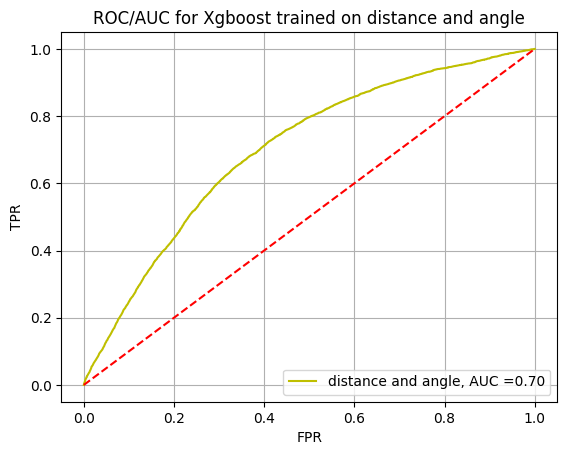

In [7]:
xgboost1=load(xgboost1_path)
val_res = xgboost1.predict_proba(val_X_1)
fpr,tpr,threshold,roc_auc_score = roc_auc_plot(val_Y,val_res,'Xgboost','distance and angle')

In [8]:
metrics.precision_score(val_Y,xgboost1.predict(val_X_1))

0.5

In [9]:
metrics.recall_score(val_Y,xgboost1.predict(val_X_1))

0.002540220152413209

##### Goal rate

In [10]:
probas_and_label = helper_df(val_Y,val_res)
probas_and_label

,is_goal,goal_proba,#goal+#shot,#goal,#goal/#goal+#shot,rank,goal_prob_sum,goal_prob_cumulative_sum,cum_percent
112161,1,0.654373,1,0.0,0.000000,99.999221,952631.01082,0.000000,0.000000
198479,0,0.654373,2,1.0,50.000000,99.999221,952631.01082,50.000000,0.005249
187881,0,0.641880,3,1.0,33.333333,99.996107,952631.01082,83.333333,0.008748
1400,0,0.641880,4,1.0,25.000000,99.996107,952631.01082,108.333333,0.011372
86494,1,0.611886,5,1.0,20.000000,99.990657,952631.01082,128.333333,0.013471
...,...,...,...,...,...,...,...,...,...
172428,0,0.000782,64218,5905.0,9.195241,0.005450,952631.01082,952594.231287,99.996139
50639,0,0.000782,64219,5905.0,9.195098,0.005450,952631.01082,952603.426385,99.997104
267596,0,0.000782,64220,5905.0,9.194955,0.005450,952631.01082,952612.621340,99.998070
245298,0,0.000782,64221,5905.0,9.194812,0.005450,952631.01082,952621.816152,99.999035


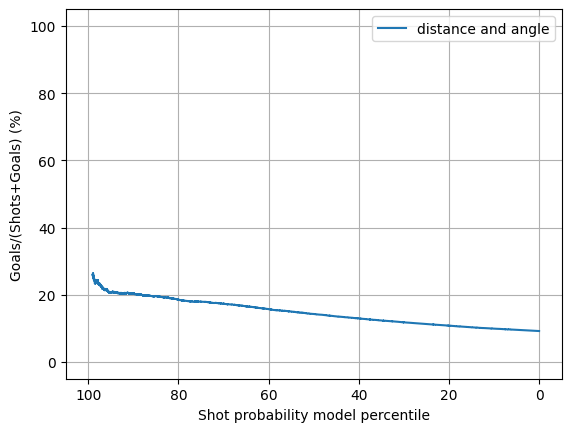

In [11]:
start_length = int(len(probas_and_label)*0.01)
plt.plot(probas_and_label['rank'].iloc[start_length:],probas_and_label['#goal/#goal+#shot'].iloc[start_length:],label="distance and angle")
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Goals/(Shots+Goals) (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()

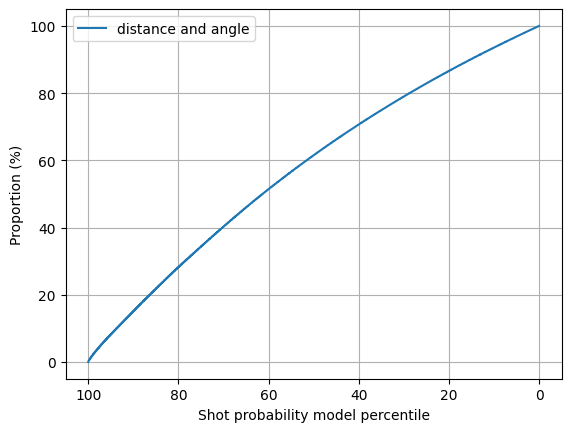

In [12]:
plt.plot(probas_and_label['rank'],probas_and_label['cum_percent'],label="distance and angle")
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Proportion (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()

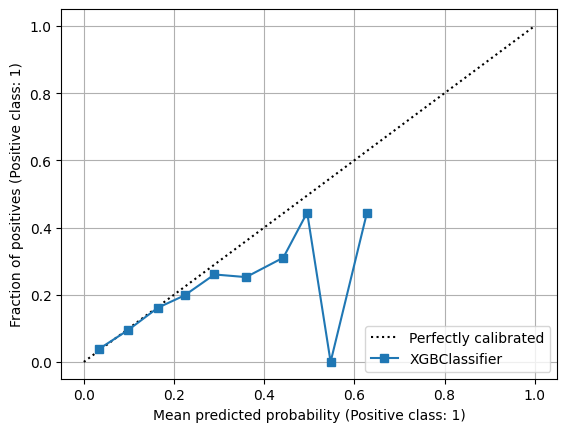

In [13]:
disp = CalibrationDisplay.from_estimator(xgboost1,val_X_1,val_Y,n_bins=15)
plt.grid(True)

### 1. Train with **features in part4**

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from bayes_opt import BayesianOptimization

In [15]:
train_val_df.columns

Index(['game_id', 'event_idx', 'play_type', 'shot_type', 'shot_dist',
       'game_time', 'goals_home', 'goals_away', 'attack_team_name', 'period',
       'period_time_rem', 'coordinate', 'shooter_name', 'goalie_name',
       'empty_Net', 'strength', 'rink_side', 'last_event_type',
       'x_coord_last_event', 'y_coord_last_event', 'Time_from_the_last_event',
       'Distance_from_the_last_event', 'Rebound', 'change_shot_angle', 'Speed',
       'x', 'y', 'angle_net', 'is_goal'],
      dtype='object')

In [16]:
features_2 = ['game_time','period','x','y','shot_type','last_event_type',
       'x_coord_last_event', 'y_coord_last_event', 'Time_from_the_last_event',
       'Distance_from_the_last_event', 'Rebound', 'change_shot_angle', 'Speed',
       'angle_net', 'is_goal']
train_X_2,train_Y,val_X_2,val_Y = split_data(train_val_df,features_2,0.25,True)
train_X_2['Rebound'] = train_X_2['Rebound'].astype(int)
train_X_2

,game_time,period,x,y,shot_type,last_event_type,x_coord_last_event,y_coord_last_event,Time_from_the_last_event,Distance_from_the_last_event,Rebound,change_shot_angle,Speed,angle_net,is_goal
179514,349,1,44.0,-26.0,Wrist Shot,Blocked Shot,-50.0,-22.0,37,94.085068,0,NaN,2.542840,-30.000000,0
92786,194,2,-46.0,-20.0,Slap Shot,Faceoff,-69.0,-22.0,5,23.086793,0,NaN,4.617359,24.000000,0
164104,835,2,-73.0,-5.0,Slap Shot,Faceoff,-69.0,-22.0,21,17.464249,0,NaN,0.831631,17.000000,0
3442,727,2,-67.0,1.0,Snap Shot,Blocked Shot,-61.0,-1.0,3,6.324555,0,NaN,2.108185,-2.602562,1
6752,434,3,79.0,0.0,Wrist Shot,Shot,87.0,-4.0,6,8.944272,1,63.434949,1.490712,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183876,211,3,39.0,-22.0,Wrist Shot,Shot,-35.0,34.0,29,92.800862,1,-39.082779,3.200030,-23.000000,0
122448,1032,2,49.0,-29.0,Slap Shot,Shot,75.0,4.0,6,42.011903,1,-51.887508,7.001984,-35.000000,0
180502,867,1,-57.0,-9.0,Snap Shot,Faceoff,-69.0,-22.0,4,17.691806,0,NaN,4.422952,15.708638,0
44510,288,3,29.0,1.0,Wrist Shot,Missed Shot,73.0,-11.0,6,45.607017,0,NaN,7.601170,0.000000,0


##### One hot encoding 

In [18]:
train_X_2_shot_type_oh = onehot_generator(train_X_2[['shot_type']])
train_X_2_last_event_type_oh = onehot_generator(train_X_2[['last_event_type']])

val_X_2_shot_type_oh = onehot_generator(val_X_2[['shot_type']])
val_X_2_last_event_type_oh = onehot_generator(val_X_2[['last_event_type']])

In [19]:
train_X_2 = train_X_2.drop(columns=['shot_type','last_event_type'])

In [20]:
train_X_2 = pd.concat([train_X_2,
                       train_X_2_shot_type_oh.set_index(train_X_2.index),
                       train_X_2_last_event_type_oh.set_index(train_X_2.index)],axis=1)

In [21]:
val_X_2 = pd.concat([val_X_2,
                       val_X_2_shot_type_oh.set_index(val_X_2.index),
                       val_X_2_last_event_type_oh.set_index(val_X_2.index)],axis=1)

In [22]:
train_X_2.columns

Index(['game_time', 'period', 'x', 'y', 'x_coord_last_event',
       'y_coord_last_event', 'Time_from_the_last_event',
       'Distance_from_the_last_event', 'Rebound', 'change_shot_angle', 'Speed',
       'angle_net', 'is_goal', 'shot_type_Backhand', 'shot_type_Deflected',
       'shot_type_Slap Shot', 'shot_type_Snap Shot', 'shot_type_Tip-In',
       'shot_type_Wrap-around', 'shot_type_Wrist Shot', 'shot_type_nan',
       'last_event_type_Blocked Shot', 'last_event_type_Faceoff',
       'last_event_type_Game Official', 'last_event_type_Giveaway',
       'last_event_type_Goal', 'last_event_type_Hit',
       'last_event_type_Missed Shot', 'last_event_type_Official Challenge',
       'last_event_type_Penalty', 'last_event_type_Period End',
       'last_event_type_Period Ready', 'last_event_type_Period Start',
       'last_event_type_Shot', 'last_event_type_Stoppage',
       'last_event_type_Takeaway'],
      dtype='object')

#### Hyperparameter tuning: Bayesian Optimization

In [23]:
params = {
    'learning_rate':(0,1),
    'max_depth':(0,100),
    'min_child_weight':(0,10),
    'sub_sample':(0,1),
    'colsample_bytree': (0,1),
    'gamma':(0,20),
    'eta':(0,1),
    'n_estimators':(50,100)
}

In [28]:
def xgboost_opti(learning_rate,max_depth,min_child_weight,sub_sample,colsample_bytree,gamma,eta,n_estimators):

    cv_score = cross_val_score(XGBClassifier(learning_rate=learning_rate,
        max_depth=int(max_depth),
        min_child_weight=min_child_weight,
        sub_sample=sub_sample,
        colsample_bytree= colsample_bytree,
        gamma=gamma,
        eta=eta,
        n_estimators=int(n_estimators)),train_X_2,train_Y)
    
    return cv_score.mean()

xgb_bo = BayesianOptimization(xgboost_opti,params)

In [29]:
xgb_bo.maximize()

|   iter    |  target   | colsam... |    eta    |   gamma   | learni... | max_depth | min_ch... | n_esti... | sub_sa... |
-------------------------------------------------------------------------------------------------------------------------


/Users/yujd10/ift6758-venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:49:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yujd10/ift6758-venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:49:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yujd10/ift6758-venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:49:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yujd10/ift6758-venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:49:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yujd10/ift6758-ve

| 1         | 1.0       | 0.2221    | 0.567     | 2.846     | 0.6738    | 62.71     | 9.926     | 95.51     | 0.3674    |


/Users/yujd10/ift6758-venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:49:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yujd10/ift6758-venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:49:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yujd10/ift6758-venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:49:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yujd10/ift6758-venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:49:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yujd10/ift6758-ve

| 2         | 1.0       | 0.5526    | 0.06767   | 11.07     | 0.5009    | 31.55     | 3.125     | 92.23     | 0.2842    |


/Users/yujd10/ift6758-venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:49:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yujd10/ift6758-venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:49:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yujd10/ift6758-venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:49:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yujd10/ift6758-venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:49:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yujd10/ift6758-ve

| 3         | 1.0       | 0.05716   | 0.9017    | 11.88     | 0.3499    | 48.31     | 4.603     | 57.37     | 0.6089    |


/Users/yujd10/ift6758-venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:49:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yujd10/ift6758-venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:49:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yujd10/ift6758-venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:49:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


KeyboardInterrupt: 